# Assignment 3: ICP + Non-linear least squares optimization

TEAM-ID: 19 <br>
TEAM-NAME: mr01  
YOUR-ID: 2019701006  
YOUR-NAME: Jeet Vora 

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)


## Instructions

* Please check Moodle for "TEAM-ID" and "TEAM-NAME" fields above. Some of your names have been edited because of redundancy/simplicity. Instructions for submitting the assignment through GitHub Classrooms/Moodle has been uploaded on Moodle. Any clarifications will be made there itself.
* Code must be written in Python in Jupyter Notebooks. You can use Assignment-1's environment for this assignment. More instructions for setup provided as you progress through this assignment.
* Both the team members must submit the zip file.
* You are not allowed to use any external libraries (other than ones being imported below).
* Answer the descriptive questions in your own words with context & clarity. Do not just copy-paste from some Wikipedia page. You will be evaluated accordingly.
* You could split the Jupyter Notebook cells where TODO is written, but please try to avoid splitting/changing the structure of other cells.

In [1]:
# Only allowed to use these libraries for this assignment. 
# Setup: Just activate Assignment-1's environment and install matplotlib `python -m pip install -U matplotlib`

import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Question 1: Simple Non-Linear least squares for Gaussian function

First, go through the [solved example here](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-13cf17d318be4d45bb8577c4d3ea4a02#1de60a8465664d39a12af24353feef9e) from the [notes page](https://www.notion.so/saishubodh/Mobile-Robotics-2020-Students-Page-0b65a9c20edd4081978f4ffad917febb#a68cabac64754fa485144cc89b4b8c65). After understanding this, 

(1.1) Code it from scratch using `numpy` and try it out yourself for say different number of iterations with a certain tolerance for all 50 observations using Gradient Descent. Make the following plots using `matplotlib`:
   * Data and fit plot: Ground truth Gaussian, observations (points) & predicted Gaussian on the same plot.
   * Cost function ($\|r\|^2$) vs number of iterations   
   
Experiment with the hyperparameters and compile your observations in a table. Clearly mention your hyperparameters with justification.

(1.2) You've used Gradient Descent above. Now implement Gauss-Newton and LM algorithms. To contrast between the three, you must experiment with 
   * Different initial estimate: Can a particular algorithm handle if the initial estimate is too far from GT?
   * Different number of observations: Can a particular algorithm handle very less observations?
   * Add [noise](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html) to your observations: Can a particular algorithm handle large noise?
   * What else can you think of? (For example, can an algorithm converge in less iterations compared to others?)
    
Make the plots (mentioned in 1.1) for all 3 algorithms. Report your observations in a table(s) (comparison between the three for different factors). You will be awarded depending on how comprehensive your experimentation is (which you have to explain below under "**Answers for Question 1**" section).

## Code for Question 1

In [2]:
# Only numpy & matplotlib is sufficient for this question.
##############################################################################
# TODO: Do tasks described in Question 1                                     #
##############################################################################
# Replace "pass" statement with your code (You can split this cell into
# multiple cells if you wish to)
class NLS_Gaussian:
    def __init__(self, num_obs, a, m, s, noise_flag=False, noise_val=0):
        self.X = np.linspace(-50,50, 1000)
        self.Y = self.gaussian_function(self.X, a, m, s)
        idx = np.random.choice(a = len(self.X), size=num_obs, replace=False)
        if not noise_flag:
            self.x_obs = self.X[idx]
            self.y_obs = self.Y[idx]
            #self.x_obs = np.array([-25,0,25])
            #self.y_obs = self.gaussian_function(self.x_obs, a, m, s)
            #print('Y observation',self.y_obs)
        else:
            noise = np.random.normal(0, noise_val, len(idx))
            self.x_obs = self.X[idx] + noise
            self.y_obs = self.Y[idx] + noise 
        self.predicted = []
        self.a, self.m, self.s = 0, 0, 0
        self.loss = []
    
    def gaussian_function(self, x, a, m, s):
        k = (-1*((x-m)**2)) / (2*(s**2))
        return a*np.exp(k)
    
    def jacobian(self, a, m, s):
        # Calculating Jacobian
        #print(self.x_obs.shape)
        diff = self.x_obs-m
        k = (-1*(diff**2)) / (2*(s**2))
        d_a = np.exp(k)
        d_m = a * (diff / s**2) * np.exp(k)
        d_s = a * ((diff**2) / s**3) * np.exp(k)
        #print(d_a.shape, d_m.shape, d_s.shape)
        return np.array([d_a, d_m, d_s]).T
    
    def update_step(self, old, lr, delta):
        delta_j = lr * delta
        #print('old',old)
        #print('deltaj',delta_j)
        new = old - delta_j
        return new
        
    def plotting(self):
        plt.figure(figsize=(20,5))
        plt.subplot(121)
        plt.title('Data and curve fit')
        plt.plot(self.X, self.Y,'b', label = 'groundtruth')
        plt.plot(self.x_obs, self.y_obs, 'go', label = 'datapoins')
        plt.plot(self.X, self.gaussian_function(self.X, self.a, self.m, self.s), 'r', label = 'predicted')
        plt.legend()
        plt.subplot(122)
        plt.title('Loss vs iterations')
        plt.plot(self.loss)
    
        
    def grad_descent(self, init_param, itr_num, lr, tol):
        self.a, self.m, self.s = init_param[0], init_param[1], init_param[2]
        loss = []
        for i in range(itr_num):
            self.predicted = self.gaussian_function(self.x_obs, self.a, self.m, self.s)
            J = self.jacobian(self.a, self.m, self.s)
            err = self.predicted - self.y_obs
            loss_i = np.sum(err**2) / len(err)
            loss.append(loss_i)
            delta = np.dot(J.T, err) 
            u = self.update_step([self.a, self.m, self.s], lr, delta)
            self.a, self.m, self.s = round(u[0],4), round(u[1],4), round(u[2],4)
        
            if loss_i<=tol:
                self.loss = loss
                break
        
        self.loss = loss
        
    def gauss_newton(self, init_param, itr_num, lr, tol):
        self.a, self.m, self.s = init_param[0], init_param[1], init_param[2]
        loss = []
        for i in range(itr_num):
            self.predicted = self.gaussian_function(self.x_obs, self.a, self.m, self.s)
            J = self.jacobian(self.a, self.m, self.s)
            err = self.predicted - self.y_obs
            loss_i = np.sum(err**2) / len(err)
            loss.append(loss_i)
            delta = np.linalg.pinv(np.dot(J.T, J)) @ J.T @ err 
            u = self.update_step([self.a, self.m, self.s], lr, delta)
            self.a, self.m, self.s = round(u[0],4), round(u[1],4), round(u[2],4)
        
            if loss_i<=tol:
                self.loss = loss
                break
        
        self.loss = loss
        

    def LM(self, init_param, itr_num, lr, tol, lambda_val):
        self.a, self.m, self.s = init_param[0], init_param[1], init_param[2]
        loss = []
        for i in range(itr_num):
            self.predicted = self.gaussian_function(self.x_obs, self.a, self.m, self.s)
            J = self.jacobian(self.a, self.m, self.s)
            err = self.predicted - self.y_obs
            loss_i = np.sum(err**2) / len(err)
            loss.append(loss_i)
            t =  np.linalg.pinv(np.dot(J.T, J))
            eye = lambda_val * np.eye(t.shape[0])
            delta = (t+eye) @ J.T @ err 
            u = self.update_step([self.a, self.m, self.s], lr, delta)
            self.a, self.m, self.s = round(u[0],4), round(u[1],4), round(u[2],4)
        
            if loss_i<=tol:
                self.loss = loss
                break
        
        self.loss = loss
        
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [3]:
def plot_estimate():
    f = NLS_Gaussian(50, 10, 0, 20, noise_flag = False, noise_val = 0)
    initial_param = np.array([10, 1, 19.5])
    f.grad_descent(initial_param,10 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a1, m1, s1, loss1 = f.a, f.m, f.s, f.loss
    print("a = %5.4f, m = %5.4f, s = %5.4f" %(f.a, f.m, f.s)) 
    
    initial_param = np.array([15, 0, 19])
    f.grad_descent(initial_param,10 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a2, m2, s2, loss2 = f.a, f.m, f.s, f.loss
    print("a = %5.4f, m = %5.4f, s = %5.4f" %(f.a, f.m, f.s))
    
    initial_param = np.array([20, 13, 30])
    f.grad_descent(initial_param,10 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a3, m3, s3, loss3 = f.a, f.m, f.s, f.loss
    print("a = %5.4f, m = %5.4f, s = %5.4f" %(f.a, f.m, f.s))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle('Different Initial Estimate plots (Question 1.1)')
    ax1.plot(f.X, f.Y,'k', label = 'groundtruth')
    ax1.plot(f.x_obs, f.y_obs, 'co', label = 'datapoins', markersize=10)
    ax1.plot(f.X, f.gaussian_function(f.X, a1, m1, s1), 'g', label = 'close')
    ax1.plot(f.X, f.gaussian_function(f.X, a2, m2, s2), 'b', label = 'not very far')
    ax1.plot(f.X, f.gaussian_function(f.X, a3, m3, s3), 'r', label = 'far')
    ax1.set_title('Data and fitting curve')
    ax1.legend()
    ax2.plot(loss1, 'g', label = 'close')
    ax2.plot(loss2, 'b', label = 'not very far')
    ax2.plot(loss3, 'r', label = 'far')
    ax2.set_title('Loss VS Iterations')
    ax2.legend()
    
def plot_itr():
    f = NLS_Gaussian(50, 10, 0, 20, noise_flag = False, noise_val = 0)
    initial_param = np.array([10, 13, 19.12])
    f.grad_descent(initial_param,10 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a1, m1, s1, loss1 = f.a, f.m, f.s, f.loss
    
    initial_param = np.array([10, 13, 19.12])
    f.grad_descent(initial_param,50 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a2, m2, s2, loss2 = f.a, f.m, f.s, f.loss
    
    initial_param = np.array([10, 13, 19.12])
    f.grad_descent(initial_param,100 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a3, m3, s3, loss3 = f.a, f.m, f.s, f.loss
    
    initial_param = np.array([10, 13, 19.12])
    f.grad_descent(initial_param,200 , 0.01, 1e-15) # LM(init_param, itr_num, lr, tol, lambda_val)
    a4, m4, s4, loss4 = f.a, f.m, f.s, f.loss
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle('Different Iterations (Question 1.1)')
    ax1.plot(f.X, f.Y,'k', label = 'groundtruth')
    ax1.plot(f.x_obs, f.y_obs, 'co', label = 'datapoins', markersize=10)
    ax1.plot(f.X, f.gaussian_function(f.X, a1, m1, s1), 'g', label = '10 iter')
    ax1.plot(f.X, f.gaussian_function(f.X, a2, m2, s2), 'b', label = '50 iter')
    ax1.plot(f.X, f.gaussian_function(f.X, a3, m3, s3), 'y', label = '100 iter')
    ax1.plot(f.X, f.gaussian_function(f.X, a4, m4, s4), 'r', label = '200 iter')
    ax1.set_title('Data and fitting curve')
    ax1.legend()
    ax2.plot(loss1, 'g', label = '10 iter')
    ax2.plot(loss2, 'b', label = '50 iter')
    ax2.plot(loss3, 'y', label = '100 iter')
    ax2.plot(loss3, 'r', label = '200 iter')
    ax2.set_title('Loss VS Iterations')
    ax2.legend()

def plot_question_2(initial_param, obs_num, itr, noise_flag, noise_val, title):
    f = NLS_Gaussian(obs_num, 10, 0, 20, noise_flag, noise_val)
    #initial_param = np.array([20, 13, 10])
    f.grad_descent(initial_param,itr , 0.01, 1e-15) # grad_descent(init_param, itr_num, lr, tol)
    a1, m1, s1, loss1 = f.a, f.m, f.s, f.loss
    
    #initial_param = np.array([20, 13, 10])
    f.gauss_newton(initial_param, itr , 0.01, 1e-15) # gauss_newton(init_param, itr_num, lr, tol)
    a2, m2, s2, loss2 = f.a, f.m, f.s, f.loss
    
    #initial_param = np.array([20, 13, 10])
    f.LM(initial_param, itr , 0.01, 1e-15, 0.1) # LM(init_param, itr_num, lr, tol, lambda_val)
    a3, m3, s3, loss3 = f.a, f.m, f.s, f.loss
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
    fig.suptitle(title + ' (Question 1.2)')
    ax1.plot(f.X, f.Y,'k', label = 'groundtruth')
    ax1.plot(f.x_obs, f.y_obs, 'co', label = 'datapoins', markersize=10)
    ax1.plot(f.X, f.gaussian_function(f.X, a1, m1, s1), 'g', label = 'Gradient Descent')
    ax1.plot(f.X, f.gaussian_function(f.X, a2, m2, s2), 'b', label = 'Gauss Newton')
    ax1.plot(f.X, f.gaussian_function(f.X, a3, m3, s3), 'r', label = 'Levenberg–Marquardt')
    ax1.set_title('Data and fitting curve')
    ax1.legend()
    ax2.plot(loss1, 'g', label = 'Gradient Descent')
    ax2.plot(loss2, 'b', label = 'Gauss Newton')
    ax2.plot(loss3, 'r', label = 'Levenberg–Marquardt')
    ax2.set_title('Loss VS Iterations')
    ax2.legend()

a = 10.1388, m = 0.8108, s = 19.6194
a = 11.0262, m = 0.4174, s = 18.2228
a = 9.3105, m = 11.0280, s = 26.7513


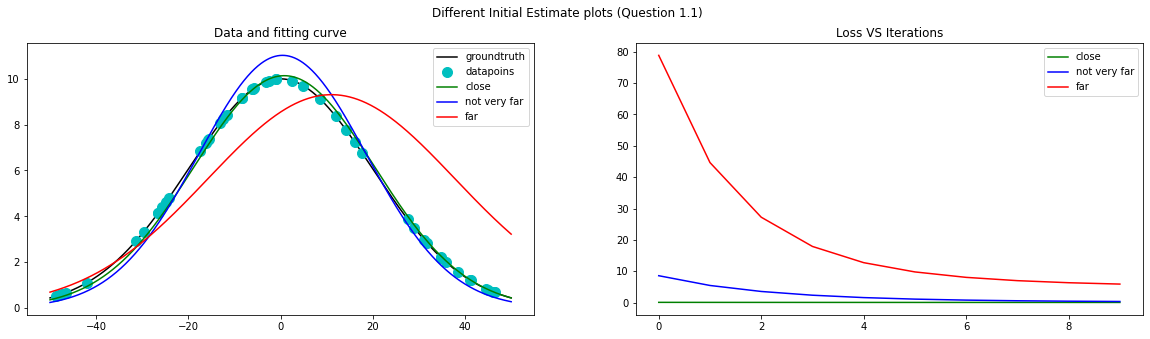

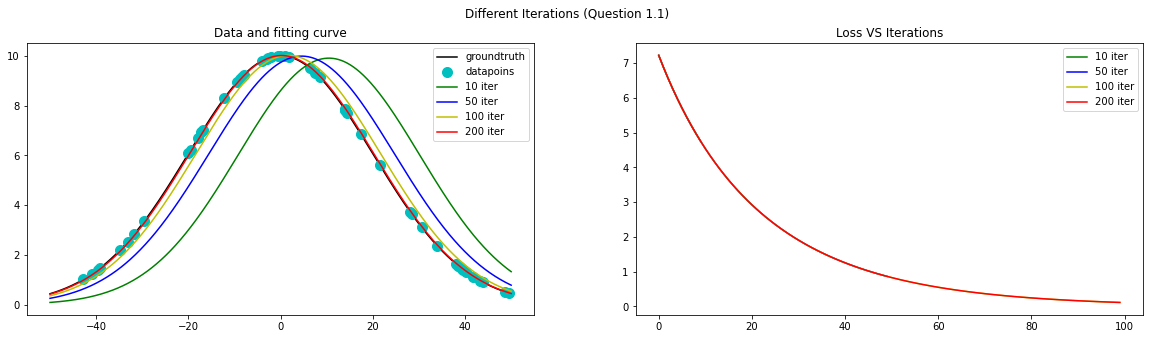

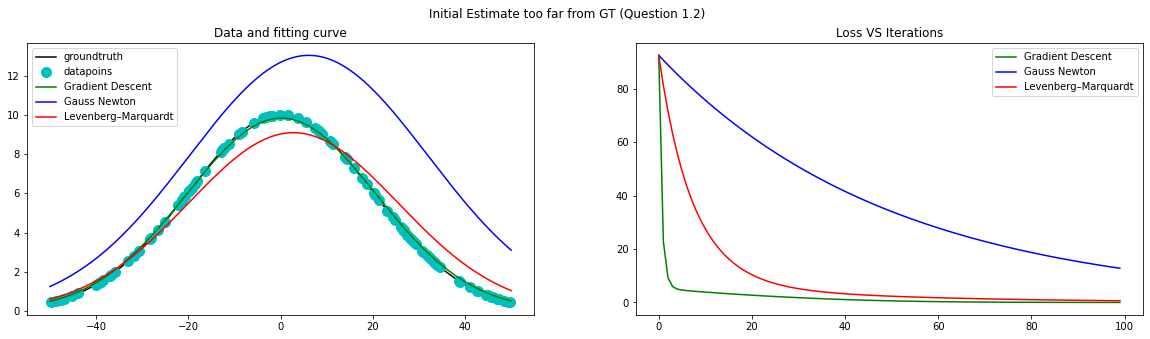

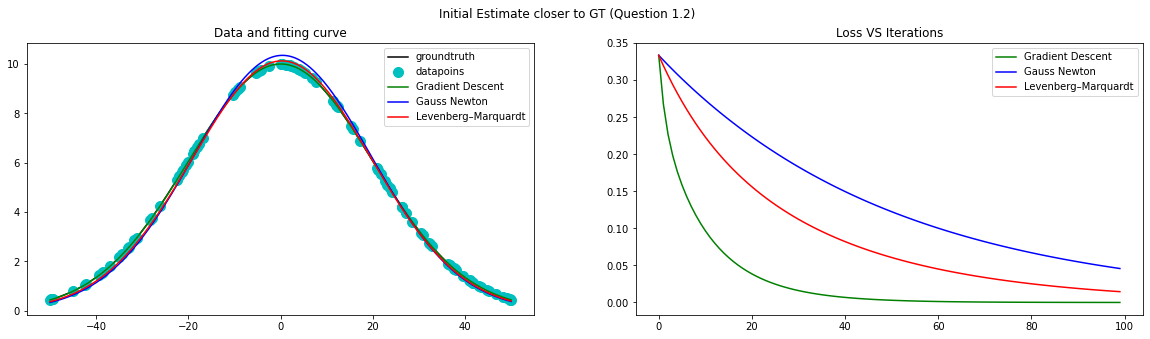

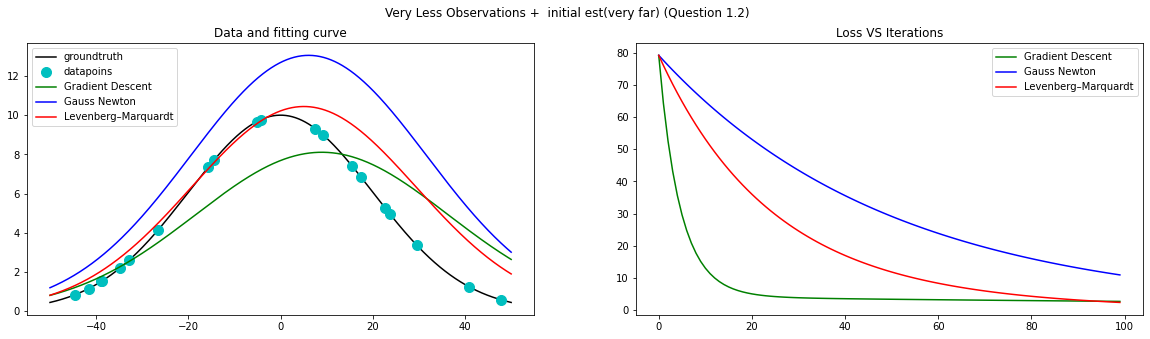

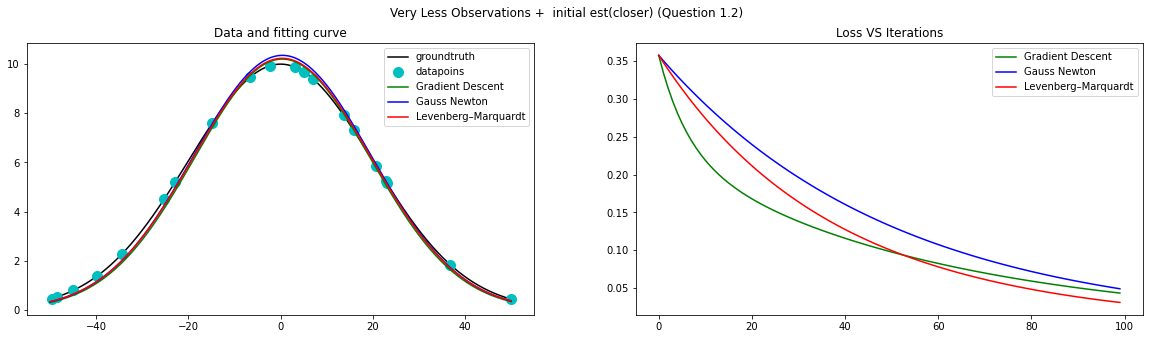

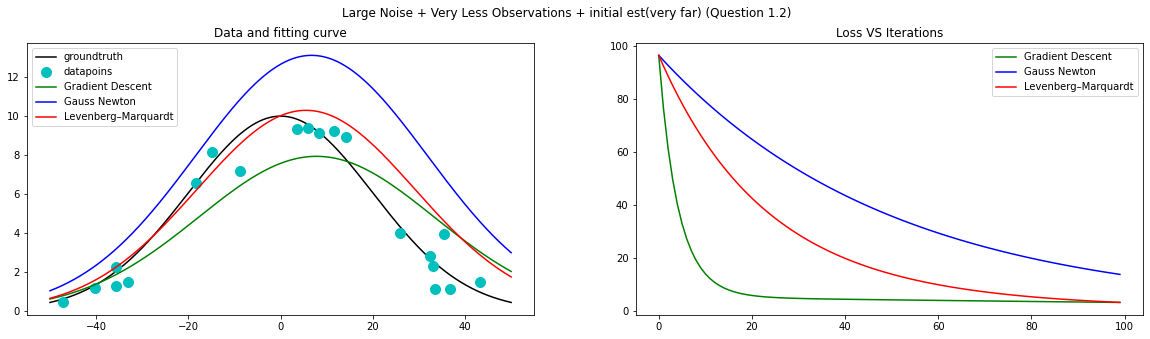

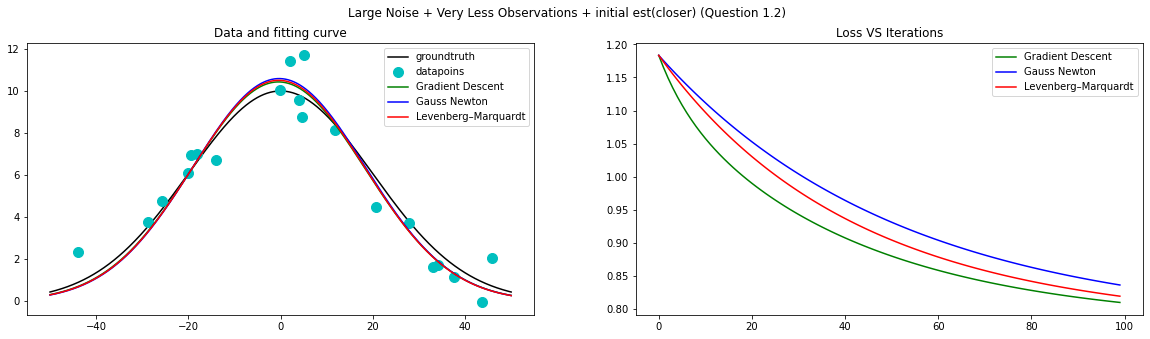

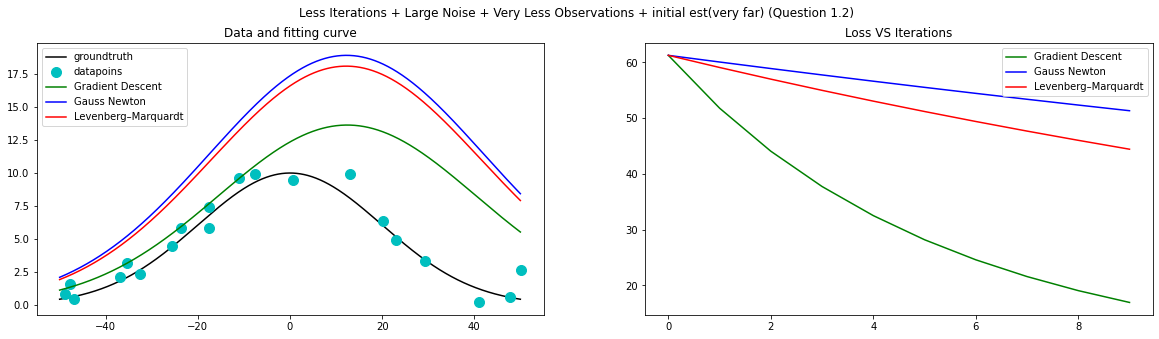

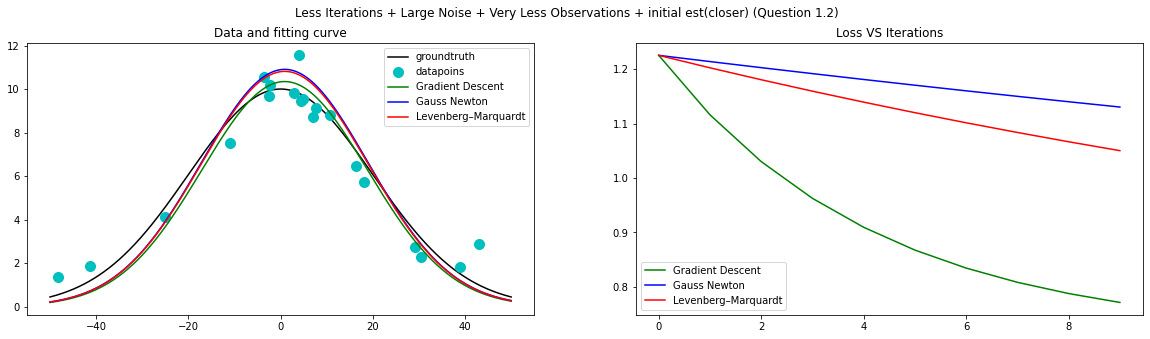

In [4]:
## Define the plots inside a function above and call them in this cell one by one. When I run this cell, all plots
## asked in Q1 should be generated. 
##############################################################################
# TODO: Plotting for Question 1                                              #
# NLS_Gaussain(num_obs, a, m, s, noise_flag, noise_val(if True))
plot_estimate()
plot_itr()

# Question 1.2
#plot_question_2(initial_param, obs_num, itr, noise_flag, noise_val, title)
init_param_far = np.array([20, 13, 30])
init_param_close = np.array([11,1,18])
plot_question_2(init_param_far, obs_num = 100, itr = 100, noise_flag = False, noise_val = 0, title = 'Initial Estimate too far from GT')
plot_question_2(init_param_close, obs_num = 100, itr = 100, noise_flag = False, noise_val = 0, title = 'Initial Estimate closer to GT')
plot_question_2(init_param_far, obs_num = 20, itr = 100, noise_flag = False, noise_val = 0, title = 'Very Less Observations +  initial est(very far)')
plot_question_2(init_param_close, obs_num = 20, itr = 100, noise_flag = False, noise_val = 0, title = 'Very Less Observations +  initial est(closer)')
plot_question_2(init_param_far, obs_num = 20, itr = 100, noise_flag = True, noise_val = 1, title = 'Large Noise + Very Less Observations + initial est(very far)')
plot_question_2(init_param_close, obs_num = 20, itr = 100, noise_flag = True, noise_val = 1, title = 'Large Noise + Very Less Observations + initial est(closer)')
plot_question_2(init_param_far, obs_num = 20, itr = 10, noise_flag = True, noise_val = 1, title = 'Less Iterations + Large Noise + Very Less Observations + initial est(very far)')
plot_question_2(init_param_close, obs_num = 20, itr = 10, noise_flag = True, noise_val = 1, title = 'Less Iterations + Large Noise + Very Less Observations + initial est(closer)')
#plot_question_2(initial_param, obs_num = 20, itr = 10, noise_flag = True, noise_val = 1, title = 'Best Algoritm')
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

## Answers for Question 1
Add explanations for the answers along with tables here.
### Answer for 1.1
Explain your experimentations with justification here

With different initial estimation on Gradient Descent, we can see from the plots as well as table that when the intial estimation is close to original estimation it perfectly fits the data(50 observations) and when estimation is far from the original estimation it does not fit the data, so there is the need to run the algorithm for more iterations until it converges and fits the data properly.
Given table clearly depicts this scenario.

|Initial estimate w.r.t to original (a = 10, m = 0, s = 20)|tolerance|iterations|final predicted parameters|converges(yes/no)|
|-------------|:------------- |:-------------:|:-------------:|:-------------:|
|close (a = 10, m = 1, s = 19.5)|1e-15 |10| (a = 10.0541, m = 0.7784, s = 19.6272)| yes|
|||50| (a = 10.0173, m = 0.4597, s = 19.7095)|yes|
|||100| (a = 9.9997, m = 0.1057, s = 19.9749)|yes|
|||200| (a = 10.0051, m = 0.0323, s = 19.9709)|yes|
|not very far (a = 15, m = 0, s = 19)|1e-15|10| (a = 10.129, m = 7.3856, s = 18.5652) |no|
|||50| (a = 9.8030, m = 3.8227, s = 18.4065)|no|
|||100| (10.1888, m = 0.0707, s = 19.4687)|yes|
|||200| (a = 10.0248, m = 0.2032, s = 19.8515)|yes|
|far (a = 20, m = 13, s = 30)|1e-15|10| (a = 8.1763, m = 11.2288, s = 27.7377) |no|
|||50| (a = 7.8005, m = 6.8110, s = 25.8277)|no|
|||100| (a = 8.4780, m = 4.3110, s = 24.5960)|no|
|||200| (a = 9.9440, m = 0.1493, s = 20.2077)|yes|


### Answer for 1.2
Explain your experimentations with justification here
1. ) Gradient Descent - the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction.
2. ) Gauss Newton - it presumes that the objective function is approximately quadratic in the parameters near the  optimal  solution.
3. ) Levenberg–Marquardt - it adaptively varies the parameter updates betweenthe gradient descent update and the Gauss-Newton update, where small values of the damping parameter (λ) result in a Gauss-Newton update and large values of (λ) result in a gradient descent update. 

Case I (initial estimate) :

| Experiments|Gradient Descent|Gauss Newton|Levenberg–Marquardt|
| ------------- |:-------------:| -------:|-------:|
| Initial estimate (very far from GT)| good|poor|average|
| Initial estimate (closer to GT)| good|good|good|

Case II (observations) :  

| Experiments|Gradient Descent|Gauss Newton|Levenberg–Marquardt|
| ------------- |:-------------:| -------:|-------:|
| Very Less Observations + initial est(very far)| good|poor|good|
| Very Less Observations + initial est(closer)| average|good|good|

Case III (Noise) :

| Experiments|Gradient Descent|Gauss Newton|Levenberg–Marquardt|
| ------------- |:-------------:| -------:|-------:|
| Large Noise + Very Less Observations + initial est(very far)| good|poor|good|
| Large Noise + Very Less Observations + initial est(closer)| good|good|good|

Case IV (Iterations) :

| Experiments|Gradient Descent|Gauss Newton|Levenberg–Marquardt|
| ------------- |:-------------:| -------:|-------:|
| Less Iterations + Large Noise + Very Less Observations + initial est(very far)| good|poor|average|
| Less Iterations + Large Noise + Very Less Observations + initial est(closer)| average|good|good|

Conclusion :
From the plots and above table,

1. Initial estimation is important hyperparameter, beacuse the performance of the methods is largely based on this hyperparameter.
2. When initial estimate is far from GT, Gauss Newton does not perform well in all the scenarios, GD and LM performs better.
3. When initial estimate is closer to GT, Gauss Newton performs better than GD as well as LM in all scenarios. LM performs better than GD when large noise, less observations and less iterations are present.
4. Since LM method is combination of both GD and Gauss Newton, it is best method for solving Non-Linear Least Squares because for initial estimate very far from GT, LM performs similar to GD while updating in steepest direction and as it reaches near optimal value (i.e closer to GT) it performs as Gauss Newton that better approximates in quadratic form, and the solution typically accelerates to the local minimum.


# Question 2: ICP Coding
Implement basic ICP algorithm with (given) known correspondences. 

Let X be your point cloud observed from the initial position. Your robot moved and observed P1 as your current point cloud. Same with P2 under a different transformation. Now you wish to apply ICP to recover transformation between (X & P1) and (X & P2). Use *root mean squared error (rmse)* as the error metric.

In [5]:
# HELPER FUNCTIONS: DON'T EDIT THIS BLOCK - If you want to test on more cases, you can add code to this block but
# DON'T delete existing code.


# Visualizing ICP registration
def plot_icp(X, P, P0, i, rmse):
    plt.cla()
    plt.scatter(X[0,:], X[1,:], c='k', marker='o', s=50, lw=0)
    plt.scatter(P[0,:], P[1,:], c='r', marker='o', s=50, lw=0)
    plt.scatter(P0[0,:], P0[1,:], c='b', marker='o', s=50, lw=0)
    plt.legend(('X', 'P', 'P0'), loc='lower left')
    plt.plot(np.vstack((X[0,:], P[0,:])), np.vstack((X[1,:], P[1,:])) ,c='k')
    plt.title("Iteration: " + str(i) + "  RMSE: " + str(rmse))
    plt.axis([-10, 15, -10, 15])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()
    plt.pause(2)
    return

# Generating data for our simple ICP
def generate_data():
  
    # create reference data  
    X = np.array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 9, 9, 9, 9],
                [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,-1,-2,-3,-4,-5]])
    
    # add noise
    P = X + 0.05 * np.random.normal(0, 1, X.shape)
    
    # translate
    P[0,:] = P[0,:] + 1
    P[1,:] = P[1,:] + 1
    
    # rotate
    theta1 = ( 10.0 / 360) * 2 * np.pi
    theta2 = (110.0 / 360) * 2 * np.pi
    rot1 = np.array([[math.cos(theta1), -math.sin(theta1)],
                    [math.sin(theta1),  math.cos(theta1)]])
    rot2 = np.array([[math.cos(theta2), -math.sin(theta2)],
                    [math.sin(theta2),  math.cos(theta2)]])
    
    # sets with known correspondences
    P1 = np.dot(rot1, P)
    P2 = np.dot(rot2, P)
  
    return X, P1, P2

In [6]:
def error_rmse(X, P):
    
    assert X.shape == P.shape

    # translate points to their centroids
    centroid_X = np.mean(X, axis=1)
    centroid_P = np.mean(P, axis=1)
    centroid_X = centroid_X.reshape((2,1))
    centroid_P = centroid_P.reshape((2,1))
    X_prime = X - centroid_X
    P_prime = P - centroid_P

    # rotation matrix
    H = np.dot(X_prime, P_prime.T)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)

    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[m-1,:] *= -1
        R = np.dot(Vt.T, U.T)

    # translation
    t = centroid_P - np.dot(R,centroid_X)

    diff = X_prime - np.dot(P_prime.T,R).T - t
    diff_sq = (diff**2)
    rmse = (np.sqrt(np.sum(diff_sq)))/len(diff)

    return rmse, R, t


In [7]:
def ICP(X, P):
    num_iter = 10 #Experiment & check if your theoretical understanding is␣, → correct.
    
    P0 =  P
    for i in range(num_iter):
        # implementing ICP:
        
        # TODO2.1: what's current error?
        rmse ,R,t = error_rmse(X,P)
        #P = np.dot(R,P) + t
        t = t.reshape((len(t),1))
        P = np.dot(R,P) + t
        print("rmse " , rmse)
        # TODO2.2: call visualization helper function plot_icp.
        plot_icp(X,P,P0,i,rmse)
        
        # TODO2.3: Implement ICP to get R, t - final result in next cell
    #return R ,t

In [8]:
X,P1,P2 = generate_data()

ITERATION for X and P1
rmse  2.8187658290196764


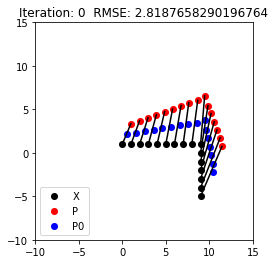

rmse  5.61259043395689


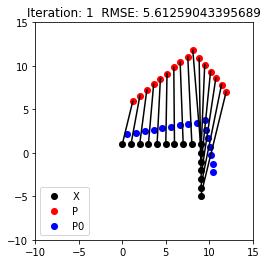

rmse  11.057424530329861


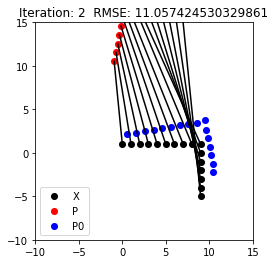

rmse  20.81744492805715


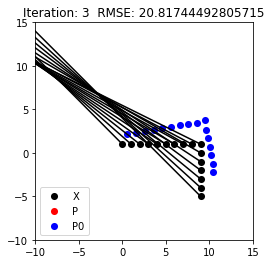

rmse  32.15753832686961


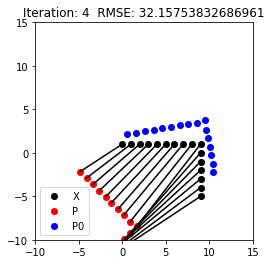

rmse  12.422052284631523


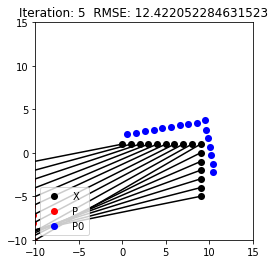

rmse  22.989853128072383


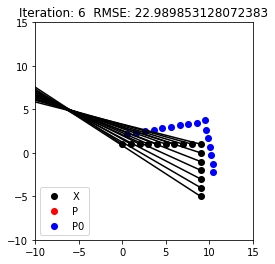

rmse  32.7704416593387


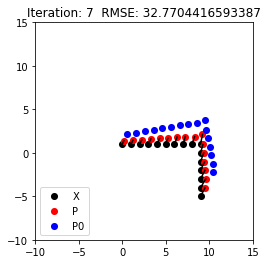

rmse  1.0521845767952878


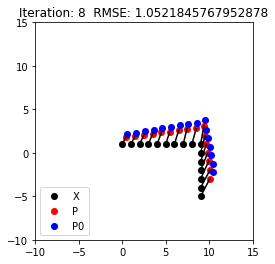

rmse  2.092250413237278


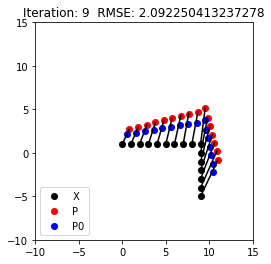

In [9]:
# Call ICP on P1 & P2
print("ITERATION for X and P1")
ICP(X,P1) #Uncomment this

ITERATION for X and P2
rmse  2.8187658290196786


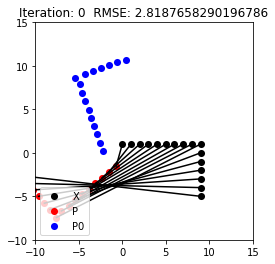

rmse  3.2385086301041808


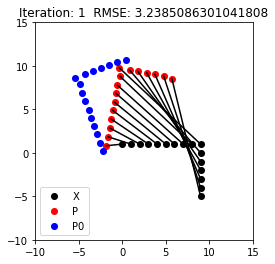

rmse  2.2020741427831676


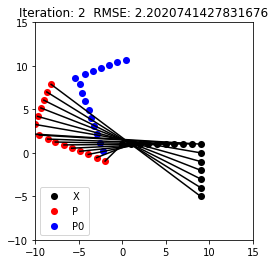

rmse  3.3846389900368945


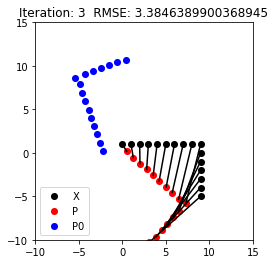

rmse  1.2468728921051222


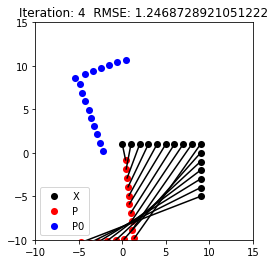

rmse  2.317723757412867


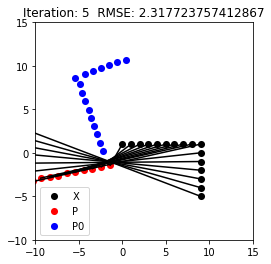

rmse  3.42737893179152


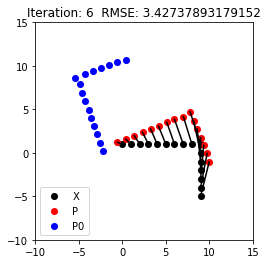

rmse  0.6631845630489748


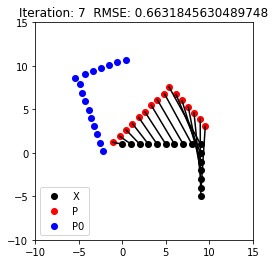

rmse  1.2852993477199395


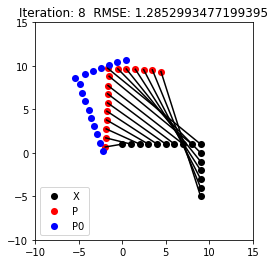

rmse  2.3783703601195767


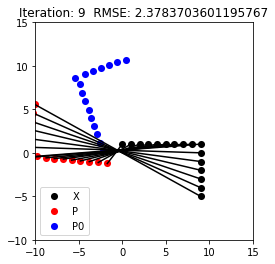

In [10]:
print("ITERATION for X and P2")
ICP(X,P2) #Uncomment this